In [ ]:
# default_exp engine.point_process

In [ ]:
%load_ext autoreload
%autoreload 2

# Emitter distribution

> Definition of the class used to simulate random emitter positions and intensities

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from decode_fish.funcs.utils import *

In [ ]:
#export
class PointProcessUniform(Distribution):
    """
    This class is part of the generative model and uses the probability local_rate to generate sample locations on the voxel grid.  
    For each emitter we then sample x-,y- and z-offsets uniformly in the range [-0.5,0.5] to get continuous locations.
    Intensities are sampled from a gamma distribution torch.distirubtions.gamma(int_conc, int_rate) which is shifted by int_loc.
    Together with the microscope.scale and the PSF this results in the overall brightness of an emitter.
    
    Args:
        local_rate torch.tensor . shape(BS, C, H, W, D): Local rate
        int_conc=0., int_rate=1., int_loc (float): parameters of the intensity gamma distribution
        sim_iters (int): instead of sampling once from local_rate, we sample sim_iters times from local_rate/sim_iters. 
            This results in the same average number of sampled emitters but allows us to sample multiple emitters within one voxel.

    """
    def __init__(self, local_rate: torch.tensor, int_conc=0., int_rate=1., int_loc=1., sim_iters: int = 5, channels=1, n_bits=1, sim_z=True, codebook=None, phase_fac=0.2):

        assert sim_iters >= 1
        self.local_rate = local_rate
        self.device = self._get_device(self.local_rate)
        self.sim_iters = sim_iters
        self.int_conc = int_conc
        self.int_rate = int_rate
        self.int_loc = int_loc
        self.channels = channels
        self.n_bits = n_bits
        self.sim_z=sim_z
        self.codebook=codebook
        self.phase_fac=phase_fac
        
    def sample(self, from_code_book=False, phasing=False):

        res_ = [self._sample(self.local_rate/self.sim_iters, from_code_book, phasing) for i in range(self.sim_iters)]
        locations = torch.cat([i[0] for i in res_], dim=0)
        x_offset = torch.cat([i[1] for i in res_], dim=0)
        y_offset = torch.cat([i[2] for i in res_], dim=0)
        z_offset = torch.cat([i[3] for i in res_], dim=0)
        intensities = torch.cat([i[4] for i in res_], dim=0)

        return list(locations.T), x_offset, y_offset, z_offset, intensities, res_[0][5]

    def _sample(self, local_rate, from_code_book, phasing):

        output_shape = list(local_rate.shape)
        local_rate = torch.clamp(local_rate,0.,1.)
        locations = D.Bernoulli(local_rate).sample()
        n_emitter = int(locations.sum().item())
        zero_point_five = torch.tensor(0.5, device=self.device)
        x_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        y_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        z_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter*self.n_bits]).to(self.device) + self.int_loc    
        
        # If 2D data z-offset is 0
        if not self.sim_z:
            z_offset *= 0
    
        locations = locations.nonzero(as_tuple=False)

        if self.channels > 1:
            if from_code_book:
                ch_draw = torch.randint(0, len(self.codebook),size=[n_emitter])
                ch_draw = self.codebook[ch_draw]
            else:
                ch_draw = torch.multinomial(torch.ones([n_emitter,self.channels])/self.channels, self.n_bits, replacement=False)
            locations = locations.repeat_interleave(self.n_bits, 0)
            locations[:, 1] = ch_draw.reshape(-1)
            
            # Exact positions are shared, but not intensities. Problems due to drift?
            x_offset = x_offset.repeat_interleave(self.n_bits, 0)
            y_offset = y_offset.repeat_interleave(self.n_bits, 0)
            z_offset = z_offset.repeat_interleave(self.n_bits, 0)
            
            output_shape[1] = self.channels
            
            if phasing:
                locations = locations.repeat_interleave(2, 0)
                locations[1::2,1] = locations[1::2,1] + 1
                x_offset = x_offset.repeat_interleave(2, 0)
                y_offset = y_offset.repeat_interleave(2, 0)
                z_offset = z_offset.repeat_interleave(2, 0)       
                intensities = intensities.repeat_interleave(2, 0)   
                
                phase_facs = torch.rand(size=intensities[1::2].shape, device=intensities.device) * self.phase_fac
                intensities[1::2] = intensities[1::2]*phase_facs
                
                inds = [locations[:,1] < self.channels][0]
                x_offset, y_offset, z_offset = x_offset[inds], y_offset[inds], z_offset[inds]
                intensities = intensities[inds]
                locations = locations[inds]
            
        return locations, x_offset, y_offset, z_offset, intensities, tuple(output_shape)


    def log_prob(self, locations, x_offset=None, y_offset=None, z_offset=None, intensities=None, output_shape=None):
        locations = list_to_locations(locations, output_shape)
        log_prob = D.Bernoulli(self.local_rate).log_prob(locations)
        return log_prob

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')
    

def list_to_locations(locations, output_shape):
    tmp =torch.zeros(output_shape, device=locations[0].device)
    coord = torch.stack(locations).T
    #incase you have multiple emitter present
    for i in coord: tmp[tuple(i)] += 1
    return tmp

In [ ]:
from decode_fish.funcs.merfish_eval2 import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([2,1,1,48,48])*.3, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=16, n_bits=4, codebook=torch.tensor(code_inds))
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(from_code_book=False, phasing=True)

(array([ 0.,  0.,  3., 21., 22., 41., 51., 36., 30., 36., 19., 12., 10.,
         8.,  6., 10.,  2.,  2.,  1.,  3.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

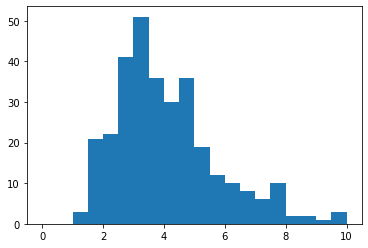

In [ ]:
plt.hist(ints_3d[locs_3d[1] == 0].numpy(), bins=np.linspace(0,10,21))

In [ ]:
b_inds = [0] + list(np.diff(x_os_3d).nonzero()[0]+1) + [len(x_os_3d)]

In [ ]:
loc_idx = []
for i in range(len(b_inds)  -1):
    loc_idx += [i] * (b_inds[i+1] - b_inds[i])

In [ ]:
def sample_to_df(locs, x_os, y_os, z_os, ints, px_size_zyx=[100,100,100], channels=16, n_bits=4):
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 
    
    b_inds = [0] + list(np.diff(x_os_3d).nonzero()[0]+1) + [len(x_os_3d)]
    n_gt = len(b_inds) - 1

    frame_idx = locs[0]
    ch_idx = locs[1]
    
    loc_idx = []
    for i in range(n_gt):
        loc_idx += [i] * (b_inds[i+1] - b_inds[i])
    
    df = DF({'loc_idx': loc_idx,
             'frame_idx': frame_idx.cpu(),
             'ch_idx': ch_idx.cpu(),
             'x': x.cpu()*px_size_zyx[2],
             'y': y.cpu()*px_size_zyx[1], 
             'z': z.cpu()*px_size_zyx[0],
             'int': ints.cpu()}) 
    
    int_arr = np.zeros([n_gt, channels])
    int_arr[df['loc_idx'], df['ch_idx']] = ints.cpu()
    
    df = df.iloc[b_inds[:-1]]
    for i in range(16):
        df[f'int_{i}'] = int_arr[:,i]

    return df

In [ ]:
# from decode_fish.funcs.output_trafo import sample_to_df
target_df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, px_size_zyx=[100,100,100])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted index.ipynb.
